In [106]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150

In [107]:
import os#环境代理设置
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

In [108]:
model_ckpt = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)

In [109]:
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)
config = AutoConfig.from_pretrained(model_ckpt)

In [110]:
def scaled_dot_product_attention(q,k,v):
    dim_k = k.size(-1)
    atten_scores = torch.bmm(q,k.transpose(-1,-2))/np.sqrt(dim_k)
    atten_weight = F.softmax(atten_scores, dim=-1)
    return torch.bmm(atten_weight, v)

In [111]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.Wq = nn.Linear(embed_dim, head_dim)
        self.Wk = nn.Linear(embed_dim, head_dim)
        self.Wv = nn.Linear(embed_dim, head_dim)
    def forward(self, x):
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        attn_outputs = scaled_dot_product_attention(q,k,v)
        return attn_outputs

In [112]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [113]:
class MutiHeadAttention(nn.Module):
    def __init__(self, config, *args, **kwargs):
        super().__init__(*args, **kwargs)
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList([
            AttentionHead(embed_dim, head_dim) for _ in range(num_heads)
        ])
        self.output_layer = nn.Linear(embed_dim, embed_dim)
    def forward(self, x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.output_layer(x)
        return x

In [114]:
mha = MutiHeadAttention(config=config)

In [115]:
token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)

In [116]:
text = "time flies like an arrow"
model_inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False)
model_inputs

{'input_ids': tensor([[ 2051, 10029,  2066,  2019,  8612]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [117]:
input_embeddings = token_embedding(model_inputs['input_ids'])
input_embeddings.shape

torch.Size([1, 5, 768])

In [118]:
attn_output = mha(input_embeddings)

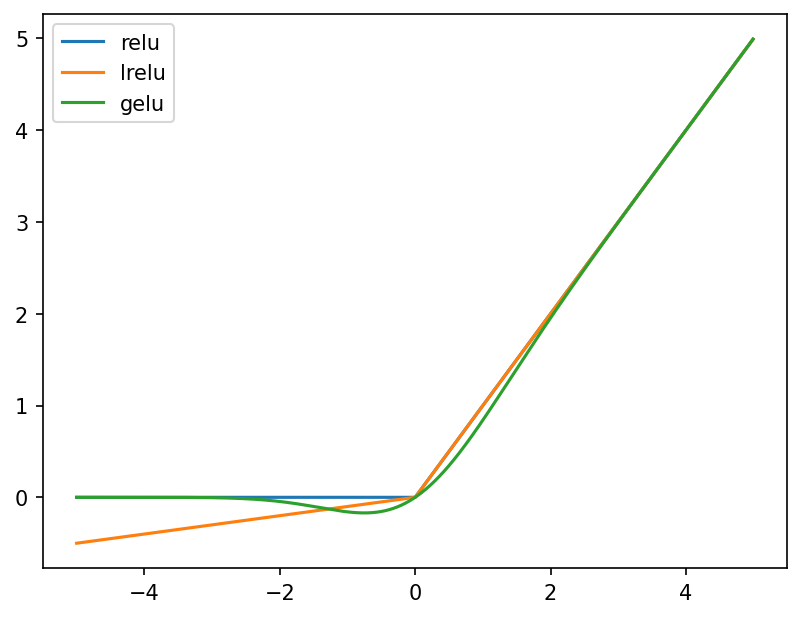

In [119]:
x = np.arange(-5, 5, 0.01)
plt.plot(x, nn.ReLU()(torch.from_numpy(x)))
plt.plot(x, nn.LeakyReLU(negative_slope=0.1)(torch.from_numpy(x)))
plt.plot(x, nn.GELU()(torch.from_numpy(x)))
plt.legend(['relu', 'lrelu', 'gelu'])

In [122]:
class FeedFoward(nn.Module):
    def __init__(self, config, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [123]:
ffn = FeedFoward(config)

In [124]:
ffn(attn_output).size()

torch.Size([1, 5, 768])

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 768, embedding 级别进行 0均值 1 标准差的归一化处理
        self.ln1 = nn.LayerNorm(config.hidden_size)
        self.ln2 = nn.LayerNorm(config.hidden_size)
        self.attn = MutiHeadAttention(config)
        self.ffn = FeedFoward(config)
    def forward(self, x):
        # x from embedding, (b, s, h)
        x = x + self.attn(self.ln1(x)) 
        # 为什么不是x+self.ln1(self.attn(x)) or self.ln1(x+self.attn(x))
        # 是经过验证的 pre-norm 结构，x + self.ln1(self.attn(x)) 或 self.ln1(x + self.attn(x)) 属于 post-norm 变体，已被主流实现淘汰
        x = x + self.ffn(self.ln2(x))
        return x

In [126]:
encoder_layer = TransformerEncoderLayer(config)

In [132]:
encoder_output = encoder_layer(input_embeddings)

In [133]:
encoder_output.shape

torch.Size([1, 5, 768])